# **Adaptive RAG**
Adaptive Retrieval-Augmented Generation (RAG) is a smart approach that adjusts how information is retrieved and used based on the complexity of a query. Instead of treating all queries the same way, Adaptive RAG chooses the best strategy for each query type.

In our case, system analyzes the query and decides the best way to handle it:

**Self-corrective RAG:** For questions that can be answered using the indexed data.

**Web Search:** For questions that require information not present in the index.

Research Paper: [Adaptive RAG](https://arxiv.org/pdf/2403.14403)

## **Initial Setup**

In [ ]:
! pip install --q athina faiss-gpu langgraph

In [ ]:
# set API keys
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ['ATHINA_API_KEY'] = userdata.get('ATHINA_API_KEY')

## **Indexing**

In [ ]:
# load embedding model
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [ ]:
# load data
from langchain.document_loaders import CSVLoader
loader = CSVLoader("./context.csv")
documents = loader.load()

In [ ]:
# split documents
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
documents = text_splitter.split_documents(documents)

In [ ]:
# create vectorstore
from langchain.vectorstores import FAISS
vectorstore = FAISS.from_documents(documents, embeddings)

## **Retriever**

In [ ]:
# create retriever
retriever = vectorstore.as_retriever()

## **Question Router**
The question router determines whether a query should be answered using our internal index or through a web search.

Please change the prompt based on your topics

In [ ]:
# create question router

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# define a data class
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM with function call
llm = ChatOpenAI(temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt (add only topics that are present in you vectorstore)
system = """You are an expert at routing a user question to either a vectorstore or web search.
The vectorstore contains information on the following topics:
- Finance and real estate
- Library and research topics
- Biology and microbiology
- Literature and writing
- Movies and entertainment
- Animals and nature
- History and geography
- Astronomy

If the question is related to these topics, route it to the vectorstore. Otherwise, use web search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [ ]:
question_router.invoke({"question": "how does interlibrary loan work?"})

RouteQuery(datasource='vectorstore')

In [ ]:
question_router.invoke({"question": "What is RAG?"})

RouteQuery(datasource='web_search')

## **Document Grader**
The document grader evaluates whether a document is relevant to the given query.

In [ ]:
# create grader for doc retriever
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# define a data class
class GradeDocuments(BaseModel):
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatOpenAI(temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt for the grader
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [ ]:
# testing grader example 1
question = "how does interlibrary loan work"
docs = retriever.get_relevant_documents(question)
print(retrieval_grader.invoke({"question": question, "document": docs}))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


binary_score='yes'


In [ ]:
# # testing grader example 2
# question = "What is RAG?"
# docs = retriever.get_relevant_documents(question)
# print(retrieval_grader.invoke({"question": question, "document": docs}))

## **RAG Chain**

In [ ]:
# create document chain
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate

template = """"
You are a helpful assistant that answers questions based on the following context.
Use the provided context to answer the question.
Context: {context}
Question: {question}
Answer:

"""

prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm | StrOutputParser()

In [ ]:
# response
generation = rag_chain.invoke({"context": docs, "question": question})
generation

'Interlibrary loan works by allowing patrons of one library to borrow physical materials or receive electronic documents from another library that holds the desired item. The borrowing library identifies potential lending libraries, which then deliver the item either physically or electronically. The borrowing library receives the item, delivers it to their patron, and arranges for its return if necessary. Fees may accompany interlibrary loan services, and requests can be managed through semi-automated or manual systems. Libraries negotiate for interlibrary loan eligibility, and with the increasing demand for digital materials, libraries are exploring the legal, technical, and licensing aspects of lending and borrowing ebooks through interlibrary loan.'

## **Hallucination Grader**
The hallucination grader checks whether the answer is grounded in or supported by the given set of facts

In [ ]:
# create grader for hallucination
# define a data class
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# prompt for the grader
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

## **Answer Grader**
The answer grader evaluates whether an answer effectively addresses the given question.

In [ ]:
# create grader for answer
# define a data class
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# prompt for the grader
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## **Web Search**

In [ ]:
# define web search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

## **Create Graph**

### **Define Graph State**

In [ ]:
# define a data class for state
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

In [ ]:
# define graph steps
from langchain.schema import Document

# all nodes
def retrieve(state):

    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):

    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def web_search(state):

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


# edges
def route_question(state):

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### **Build Graph**

In [ ]:
# Build graph
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "generate": "generate",
    },
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END
    },
)

# Compile
app = workflow.compile()

In [ ]:
# Final generation example 1 (relevant documents)
from pprint import pprint

inputs = {"question": "how does interlibrary loan work"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Interlibrary loan works by allowing patrons of one library to borrow '
 'physical materials or receive electronic documents from another library that '
 'holds the desired item. The borrowing library identifies potential lending '
 'libraries, and the lending library delivers the item either physically or '
 'electronically. The borrowing library then receives the item, delivers it to '
 'their patron, and arranges for its return if necess

In [ ]:
# Final generation example 2 (non-relevant documents)
from pprint import pprint

inputs = {"question": "What is RAG?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('RAG, or retrieval-augmented generation, is a method that combines retrieval '
 'models and generative models in natural language processing (NLP) to produce '
 'coherent, contextually relevant text. It allows AI models to access external '
 'knowledge bases and incorporate up-to-date information into generated '
 'responses. RAG is significant in NLP as it bridges the gap between retrieval '
 'and generative models, enhancing the accuracy and relevance of AI-generated '
 'content.')


## **Preparing Data for Evaluation**

In [ ]:
# Create a dataframe to store the question, context, and response
inputs = {"question": "how does interlibrary loan work"}
outputs = []


for output in app.stream(inputs):
    for key, value in output.items():
        if key == "generate":
            question = value["question"]
            documents = value["documents"]
            generation = value["generation"]

            # Combine document
            context = "\n".join(doc.page_content for doc in documents)

            # Append the result
            outputs.append({
                "query": question,
                "context": context,
                "response": generation,
            })

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


In [ ]:
# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(outputs)

In [ ]:
df

,query,context,response
0,how does interlibrary loan work,Procedures and methods ==\n\nAfter receiving a...,Interlibrary loan works by allowing patrons of...


In [ ]:
# Convert to dictionary
df_dict = df.to_dict(orient='records')

# Convert context to list
for record in df_dict:
    if not isinstance(record.get('context'), list):
        if record.get('context') is None:
            record['context'] = []
        else:
            record['context'] = [record['context']]

## **Evaluation in Athina AI**

We will use **Context Relevancy** eval here. It Measures the relevancy of the retrieved context, calculated based on both the query and contexts. To learn more about this. Please refer to our [documentation](https://docs.athina.ai/api-reference/evals/preset-evals/overview) for further details

In [ ]:
# set api keys for Athina evals
from athina.keys import AthinaApiKey, OpenAiApiKey
OpenAiApiKey.set_key(os.getenv('OPENAI_API_KEY'))
AthinaApiKey.set_key(os.getenv('ATHINA_API_KEY'))

In [ ]:
# load dataset
from athina.loaders import Loader
dataset = Loader().load_dict(df_dict)

In [ ]:
# evaluate
from athina.evals import RagasContextRelevancy
RagasContextRelevancy(model="gpt-4o").run_batch(data=dataset).to_df()

evaluating with [context_relevancy]


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


You can view your dataset at: https://app.athina.ai/develop/e6867bf1-6320-474b-8dca-3284b41df567


,query,context,response,expected_response,display_name,failed,grade_reason,runtime,model,ragas_context_relevancy
0,how does interlibrary loan work,"[Procedures and methods ==\n\nAfter receiving a request from their patron, the borrowing library identifies potential lending libraries with the desired item. The lending library then delivers the item physically or electronically, and the borrowing library receives the item, delivers it to their patron, and if necessary, arranges for its return. In some cases, fees accompany interlibrary loan services. While the majority of interlibrary loan requests are now managed through semi-automated\n...","Interlibrary loan works by allowing patrons of one library to borrow physical materials or receive electronic documents from another library that holds the desired item. The borrowing library identifies potential lending libraries, which then deliver the item either physically or electronically. The borrowing library receives the item, delivers it to their patron, and arranges for its return if necessary. Fees may accompany interlibrary loan services, and requests can be managed through semi...",None,Ragas Context Relevancy,None,This metric is calulated by dividing the number of sentences in context that are relevant for answering the given query by the total number of sentences in the retrieved context,1420,gpt-4o,0.1875


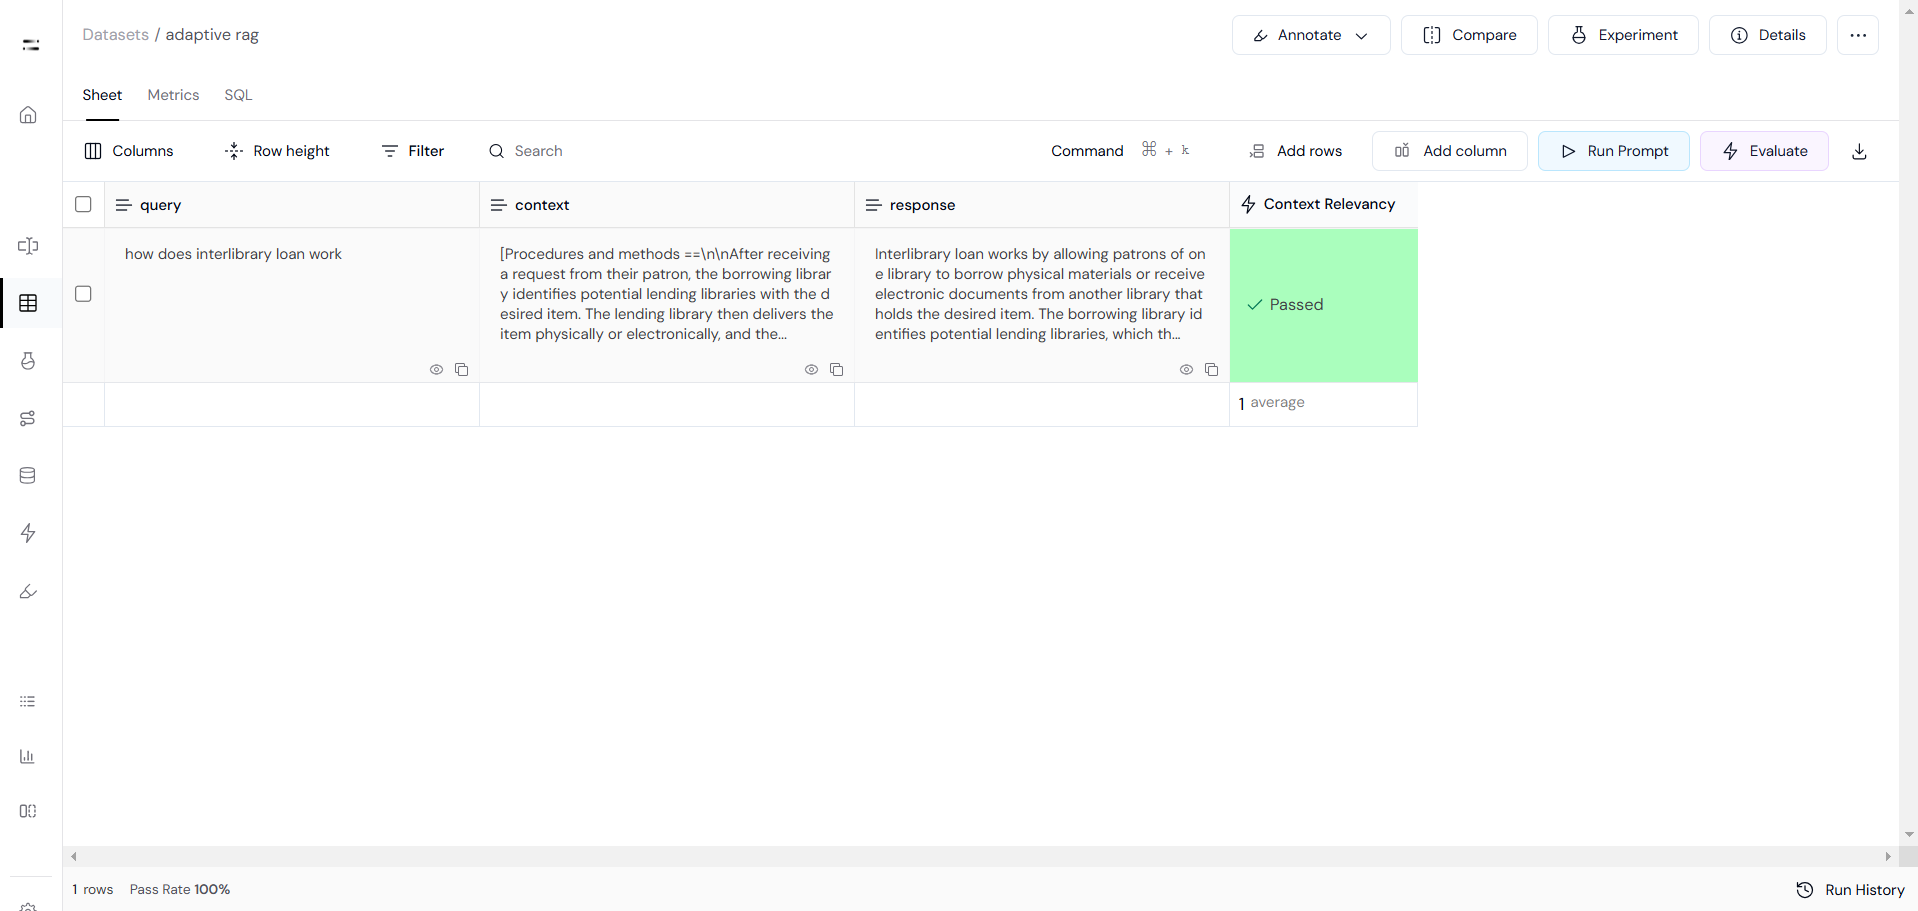